In [1]:
import os
import re
import math
import random
import torch
import torch.nn as nn
from torch.nn import functional as F
import triton
import triton.language as tl
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython import display
# os.environ["TRITON_INTERPRET"] = "0"
torch.manual_seed(69)
torch.set_printoptions(profile="short", sci_mode=False, linewidth=100000)
# this script is configured to run on a RTX 3060 12GB GPU. you'll want to adjust the model sizes and batch sizes for other devices
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 50
plt.rcParams['axes.grid'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
device

device(type='cuda')

# Data Prep

In [2]:
# we use this 40mb file of concatenated anime subtitles as our dataset
# just the right size for toy experiments like this I think
with open('animesubs.txt', 'r', encoding='latin') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  39526018


In [3]:
print(text[:500])

Open your mind. Open your mind.

Far beyond the deep blue Earth, you and I shall meet...

AH! MY GODDESS

A snow-white feather comes fluttering down, swaying gently in the air.

Without holding back, I want to envelope you, my one and only love.

I know I have the power to protect the one I love, right here in my hands.

Open your mind. Just as I've always dreamed.

Let the wind carry off your hopes, faraway.

I have wings nobody can see. Look, you have them, too.

They'll take us to where we ca


In [4]:
# remove japanese characters
text = ''.join(filter(lambda character:ord(character) < 0x3000, text))

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("unique characters:", vocab_size, ''.join(chars))

unique characters: 86 
 !'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|


In [6]:
# yes, all language models will be character level, which isn't ideal but it's good for simplicity
# very simple tokenizer
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
# add special token for padding
stoi[''] = len(stoi)
itos[len(itos)] = ''
print(stoi)
print(itos)
encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: ''.join([itos[i] for i in l])
print("encoded:", encode(text[:20]))
print("decoded:", decode(encode(text[:20])))
vocab_size = len(itos)
print("vocab size:", vocab_size)

{'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, '*': 6, '+': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '=': 25, '>': 26, '?': 27, '@': 28, 'A': 29, 'B': 30, 'C': 31, 'D': 32, 'E': 33, 'F': 34, 'G': 35, 'H': 36, 'I': 37, 'J': 38, 'K': 39, 'L': 40, 'M': 41, 'N': 42, 'O': 43, 'P': 44, 'Q': 45, 'R': 46, 'S': 47, 'T': 48, 'U': 49, 'V': 50, 'W': 51, 'X': 52, 'Y': 53, 'Z': 54, '[': 55, ']': 56, '_': 57, 'a': 58, 'b': 59, 'c': 60, 'd': 61, 'e': 62, 'f': 63, 'g': 64, 'h': 65, 'i': 66, 'j': 67, 'k': 68, 'l': 69, 'm': 70, 'n': 71, 'o': 72, 'p': 73, 'q': 74, 'r': 75, 's': 76, 't': 77, 'u': 78, 'v': 79, 'w': 80, 'x': 81, 'y': 82, 'z': 83, '|': 84, '\x94': 85, '': 86}
{0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: '*', 7: '+', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: ':', 23: ';', 24: '<', 25: '=

In [7]:
data = torch.tensor(encode(text), dtype=torch.int64)
data.shape

torch.Size([39526018])

In [8]:
data[:100]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  1, 43, 73, 62, 71,  1, 82, 72, 78, 75,  1, 70, 66, 71, 61, 10,  0,  0, 34, 58, 75,  1, 59, 62, 82, 72, 71, 61,  1, 77, 65, 62,  1, 61, 62, 62, 73,  1, 59, 69, 78, 62,  1, 33, 58, 75, 77, 65,  8,  1, 82, 72, 78,  1, 58, 71, 61,  1, 37,  1, 76, 65, 58, 69, 69,  1, 70, 62, 62, 77, 10, 10, 10,  0,  0, 29, 36,  2,  1, 41, 53,  1, 35, 43, 32])

In [9]:
n = int(len(data) * 0.99)
train_data = data[:n]
val_data = data[n:]
print(train_data.shape, val_data.shape)

torch.Size([39130757]) torch.Size([395261])


In [10]:
seq_len = 8
train_data[:seq_len+1]

tensor([43, 73, 62, 71,  1, 82, 72, 78, 75])

In [11]:
def get_batch(split, seq_len, batch_size=4):
    # generate a small batch of data of inputs x and targets y
    # targets are just inputs shifted by 1
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - seq_len, (batch_size,))
    x = torch.stack([data[i:i+seq_len] for i in ix])
    y = torch.stack([data[i+1:i+seq_len+1] for i in ix])
    return x.to(device), y.to(device)

xb, yb = get_batch('train', 64, 2)
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

inputs:
torch.Size([2, 64])
tensor([[64,  1, 72, 78, 75,  1, 66, 71, 77, 62, 75, 71, 76, 65, 66, 73, 76, 10,  0,  0, 48, 65, 62,  1, 71, 66, 64, 65, 77,  1, 37, 66, 61, 58,  1, 64, 72, 77,  1, 77, 65, 62,  1, 75, 62, 76, 78, 69, 77, 76,  1, 72, 63,  1, 77, 65, 62,  1, 62, 81, 58, 70, 66, 71],
        [62, 70,  2,  0,  0, 37, 77,  1, 69, 72, 72, 68, 76,  1, 69, 66, 68, 62,  1, 80, 62,  1, 77, 72, 72, 68,  1, 60, 58, 75, 62,  1, 72, 63,  1, 77, 65, 62, 70, 10,  0,  0, 48, 65, 72, 76, 62,  1, 64, 78, 82, 76,  1, 80, 62, 75, 62,  1, 66, 71, 60, 75, 62, 61]], device='cuda:0')
targets:
torch.Size([2, 64])
tensor([[ 1, 72, 78, 75,  1, 66, 71, 77, 62, 75, 71, 76, 65, 66, 73, 76, 10,  0,  0, 48, 65, 62,  1, 71, 66, 64, 65, 77,  1, 37, 66, 61, 58,  1, 64, 72, 77,  1, 77, 65, 62,  1, 75, 62, 76, 78, 69, 77, 76,  1, 72, 63,  1, 77, 65, 62,  1, 62, 81, 58, 70, 66, 71, 58],
        [70,  2,  0,  0, 37, 77,  1, 69, 72, 72, 68, 76,  1, 69, 66, 68, 62,  1, 80, 62,  1, 77, 72, 72, 68,  1, 60, 58, 75, 62

# Training Prep

In [12]:
# Make all steps, sequence lengths, and batch size the same
total_steps = 5000
seq_len = 2048
batch_size = 8 # these are small models so we can use large batch sizes to fully utilize the GPU
# should cover around 2x the dataset
total_steps * seq_len * batch_size

81920000

In [13]:
def train(model, optimizer, seq_len, batch_size, total_steps, val_steps=10, val_interval=50):
    losses = []
    val_losses = []
    # live plot
    fig, ax = plt.subplots()
    dh = display.display(fig, display_id=True)
    for steps in (bar := tqdm(range(total_steps))):  # increase number of steps for good results...
        # sample a batch of data
        xb, yb = get_batch('train', seq_len=seq_len, batch_size=batch_size)

        # evaluate the loss
        logits, loss = model(xb, yb)

        # backprop
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        bar.set_description(f"loss: {loss.item():.2f}, val loss: {val_losses[-1] if val_losses else 0:.2f}")
        losses.append(loss.item())
        if steps % val_interval == 0:
            # Calculate validation loss
            with torch.no_grad():
                val_loss = 0
                for _ in range(val_steps):
                    xb, yb = get_batch('val', seq_len=seq_len, batch_size=batch_size)
                    _, loss = model(xb, yb)
                    val_loss += loss.item()
                val_loss /= val_steps
                val_losses.append(val_loss)
            ax.clear()
            ax.plot(losses, color='blue', label='train loss', alpha=0.7)
            ax.plot(range(0, len(losses), val_interval), val_losses, color='red', label='val loss', alpha=0.7)
            ax.set_ylim(0, 4)
            ax.legend()
            dh.update(fig)
    print('final loss:', loss.item(), 'final val loss:', val_loss)

In [14]:
# Measure post training perplexity on validation set
# Create function that receives a model, context length, and PPL sequence length, and returns the perplexity
# The PPL sequence length is the number of characters the function uses to calculate the perplexity
# We take the logits and calculate the cross entropy loss from scratch, then exponentiate it to get the perplexity
# not only that, but we want the models to do this in actual inference
def perplexity(model, seq_len, ppl_seq_len, batch_size=128):
    with torch.no_grad():
        val_steps = 10
        val_loss = 0
        for _ in range(val_steps):
            xb, yb = get_batch('val', seq_len=seq_len, batch_size=batch_size)
            logits, _ = model(xb, yb)
            logits = logits.reshape(batch_size, seq_len, vocab_size)
            logits = logits[:, :ppl_seq_len]
            yb = yb[:, :ppl_seq_len]
            # flatten logits and targets
            logits = logits.reshape(batch_size*ppl_seq_len, vocab_size)
            yb = yb.reshape(batch_size*ppl_seq_len)
            # calculate cross entropy loss from scratch
            loss = F.cross_entropy(logits, yb)
            val_loss += loss.item()
        val_loss /= val_steps
        ppl = torch.exp(torch.tensor(val_loss))
        return ppl.item(), val_loss

# Semi-Compressed AttentioN (SCAN)

## Attend Folded Keys Kernel

In [15]:
def sliding_window_fold(x, window_len):
    # x is a (B, T, C) tensor
    # output should be a (B, T, window_len, C) tensor that slides over the T dimension
    # first window_len-1 elements will have to be padded with zeros in the beginning
    # example: x = torch.tensor([[[1,2],[3,4],[5,6],[7,8],[9,10]]])
    # sliding_window_fold(x, 2) -> torch.tensor([[[[0,1],[1,2]],[[1,2],[3,4]],[[3,4],[5,6]],[[5,6],[7,8]],[[7,8],[9,10]]]])
    padded_x = F.pad(x, (0, 0, window_len - 1, 0), mode='constant', value=0)
    output = padded_x.unfold(dimension=1, size=window_len, step=1).permute(0, 1, 3, 2)
    return output

def attend_folded_all_keys_torch(q, k, states, W):
    k = sliding_window_fold(k, W) # (B, T, W, C)
    all_keys = torch.cat((states, k), dim=2) # (B, T, S, C) + (B, T, W, C) -> (B, T, S+W, C)
    scores = torch.einsum("btc, btxc -> btx", q, all_keys) # (B, T, S+W)
    return scores

def accumulate_folded_all_values_torch(s, v, states, W):
    v = sliding_window_fold(v, W) # (B, T, W, C)
    all_values = torch.cat((states, v), dim=2) # (B, T, S, C) + (B, T, W, C) -> (B, T, S+W, C)
    out = torch.einsum("btx, btxc -> btc", s, all_values) # (B, T, C)
    return out

In [16]:
# triton kernel
@triton.jit
def afak_fwd_kernel(
    q_ptr, k_ptr, states_ptr, y_ptr,
    B: tl.constexpr, T: tl.constexpr, S:tl.constexpr, C: tl.constexpr, W: tl.constexpr,
    BLOCK_SIZE_S: tl.constexpr,
    BLOCK_SIZE_W: tl.constexpr,
):
    # Use multiple program IDs for better parallelization
    b_id = tl.program_id(axis=0)
    t_id = tl.program_id(axis=1)
    sw_block_id = tl.program_id(axis=2)
    num_s_blocks = triton.cdiv(S, BLOCK_SIZE_S)
    num_w_blocks = triton.cdiv(W, BLOCK_SIZE_W)
    SW = S + W

    # Compute base pointers
    q_base = q_ptr + b_id * T * C
    k_base = k_ptr + b_id * T * C
    states_base = states_ptr + b_id * T * S * C
    y_base = y_ptr + b_id * T * W

    # Fetch the query at [b_id, t_id, :]
    q_block_ptr = tl.make_block_ptr(
        base=q_ptr,
        shape=(B, T, C),
        strides=(T * C, C, 1),
        offsets=(b_id, t_id, 0),
        block_shape=(1, 1, C),
        order=(0, 1, 2),
    )
    q = tl.load(q_block_ptr) # (1, 1, C)

    if sw_block_id < num_s_blocks:
        s_first_id = sw_block_id * BLOCK_SIZE_S
        # Fetch the states at [b_id, t_id, s_first_id:s_first_id+BLOCK_SIZE_S, :]
        s_block_ptr = tl.make_block_ptr(
            base=states_ptr,
            shape=(B, T, S, C),
            strides=(T * S * C, S * C, C, 1),
            offsets=(b_id, t_id, s_first_id, 0),
            block_shape=(1, 1, BLOCK_SIZE_S, C),
            order=(0, 1, 2, 3),
        )
        s = tl.load(s_block_ptr) # (1, 1, BLOCK_SIZE_S, C)
        o = q[:, :, None, :] * s # (1, 1, BLOCK_SIZE_S, C)
        o = tl.sum(o, axis=-1) # (1, 1, BLOCK_SIZE_S)
        # Store the result
        y_block_ptr = tl.make_block_ptr(
            base=y_ptr,
            shape=(B, T, SW),
            strides=(T * SW, SW, 1),
            offsets=(b_id, t_id, s_first_id),
            block_shape=(1, 1, BLOCK_SIZE_S),
            order=(0, 1, 2),
        )
        tl.store(y_block_ptr, o) # (1, 1, BLOCK_SIZE_S)
    else:
        w_first_id = (sw_block_id - num_s_blocks) * BLOCK_SIZE_W
        # Fetch the key at [b_id, t_id-W+1+(w_block_id*BLOCK_SIZE_W):t_id+(w_block_id*BLOCK_SIZE_W), :]
        # need to load the keys manually because make_block_ptr doesn't support masks
        tw_offs = tl.arange(0, BLOCK_SIZE_W)
        c_offs = tl.arange(0, C)
        k_block_ptr = k_base + (t_id - W + 1 + (w_first_id + tw_offs[:, None])) * C + c_offs[None, :]
        mask = w_first_id + tl.arange(0, BLOCK_SIZE_W)[:, None] > (W - t_id - 2)
        k = tl.load(k_block_ptr, mask=mask) # (BLOCK_SIZE_W, C)
        # Compute the dot product (but not with tl.dot because it has a minimum size of 16)
        y = q * k[None, :] # (1, BLOCK_SIZE_W, C)
        y = tl.sum(y, axis=-1) # (1, BLOCK_SIZE_W)
        # Store the result
        y_block_ptr = tl.make_block_ptr(
            base=y_ptr,
            shape=(B, T, SW),
            strides=(T * SW, SW, 1),
            offsets=(b_id, t_id, S + w_first_id),
            block_shape=(1, 1, BLOCK_SIZE_W),
            order=(0, 1, 2),
        )
        tl.store(y_block_ptr, y[None, :]) # (1, 1, BLOCK_SIZE_W)

@triton.jit
def afak_bwd_kernel(
    q_ptr, k_ptr, states_ptr, dy_ptr, dq_ptr, dk_ptr, ds_ptr,
    B: tl.constexpr, T: tl.constexpr, S: tl.constexpr, C: tl.constexpr, W: tl.constexpr,
    BLOCK_SIZE_C: tl.constexpr,
):
    # Use multiple program IDs for better parallelization
    b_id = tl.program_id(axis=0)
    t_id = tl.program_id(axis=1)
    c_block_id = tl.program_id(axis=2)
    c_first_id = c_block_id * BLOCK_SIZE_C
    SW = S + W

    # Compute base pointers
    q_base = q_ptr + b_id * T * C
    k_base = k_ptr + b_id * T * C
    dy_base = dy_ptr + b_id * T * SW
    dq_base = dq_ptr + b_id * T * C
    dk_base = dk_ptr + b_id * T * C

    # First calculate the gradients for q
    # Fetch original keys at [b_id, t_id-W+1:t_id, c_first_id:c_first_id+BLOCK_SIZE_C]
    # using a block ptr also disallows the use of masks when loading, so let's just make a ptr manually
    tw_offs = tl.arange(0, W)
    c_offs = tl.arange(0, BLOCK_SIZE_C)
    k_block_ptr = k_base + (t_id - W + 1 + tw_offs[:, None]) * C + c_first_id + c_offs[None, :]
    mask = tl.arange(0, W)[:, None] > (W - t_id - 2)
    k = tl.load(k_block_ptr, mask=mask) # (W, BLOCK_SIZE_C)
    # Fetch output gradients at [b_id, t_id, S:W]
    dy_block_ptr = tl.make_block_ptr(
        base=dy_ptr,
        shape=(B, T, SW),
        strides=(T * SW, SW, 1),
        offsets=(b_id, t_id, S),
        block_shape=(1, 1, W),
        order=(0, 1, 2),
    )
    dy = tl.load(dy_block_ptr) # (1, 1, W)
    # Compute the gradients for q
    dqk = dy.permute(0, 2, 1) * k[None, :] # (1, W, BLOCK_SIZE_C)
    dqk = tl.sum(dqk, axis=1) # (1, BLOCK_SIZE_C)
    # Then we also have to add the gradients from the states
    # Fetch the states at [b_id, t_id, c_first_id:c_first_id+BLOCK_SIZE_C]
    s_block_ptr = tl.make_block_ptr(
        base=states_ptr,
        shape=(B, T, S, C),
        strides=(T * S * C, S * C, C, 1),
        offsets=(b_id, t_id, 0, c_first_id),
        block_shape=(1, 1, S, BLOCK_SIZE_C),
        order=(0, 1, 2, 3),
    )
    s = tl.load(s_block_ptr) # (1, 1, S, BLOCK_SIZE_C)
    # Fetch the output gradients at [b_id, t_id, :S]
    dy_block_ptr = tl.make_block_ptr(
        base=dy_ptr,
        shape=(B, T, SW),
        strides=(T * SW, SW, 1),
        offsets=(b_id, t_id, 0),
        block_shape=(1, 1, S),
        order=(0, 1, 2),
    )
    dy = tl.load(dy_block_ptr) # (1, 1, S)
    # Compute the gradients for q
    dqs = dy[:, :, :, None] * s # (1, 1, S, BLOCK_SIZE_C)
    dqs = tl.sum(dqs, axis=2) # (1, 1, BLOCK_SIZE_C)
    dq = dqk[None, :] + dqs # (1, 1, BLOCK_SIZE_C)
    # Store the result
    dq_block_ptr = tl.make_block_ptr(
        base=dq_ptr,
        shape=(B, T, C),
        strides=(T * C, C, 1),
        offsets=(b_id, t_id, c_first_id),
        block_shape=(1, 1, BLOCK_SIZE_C),
        order=(0, 1, 2),
    )
    tl.store(dq_block_ptr, dq) # (1, 1, BLOCK_SIZE_C)

    # Calculate the gradients for states while we're at it
    # Fetch the query at [b_id, t_id, c_first_id:c_first_id+BLOCK_SIZE_C]
    q_block_ptr = tl.make_block_ptr(
        base=q_ptr,
        shape=(B, T, C),
        strides=(T * C, C, 1),
        offsets=(b_id, t_id, c_first_id),
        block_shape=(1, 1, BLOCK_SIZE_C),
        order=(0, 1, 2),
    )
    q = tl.load(q_block_ptr) # (1, 1, BLOCK_SIZE_C)
    # Compute the gradients for states
    ds = dy[:, :, :, None] * q[:, :, None, :] # (1, 1, S, BLOCK_SIZE_C)
    # Store the result
    ds_block_ptr = tl.make_block_ptr(
        base=ds_ptr,
        shape=(B, T, S, C),
        strides=(T * S * C, S * C, C, 1),
        offsets=(b_id, t_id, 0, c_first_id),
        block_shape=(1, 1, S, BLOCK_SIZE_C),
        order=(0, 1, 2, 3),
    )
    tl.store(ds_block_ptr, ds) # (1, 1, S, BLOCK_SIZE_C)

    # Then calculate the gradients for k
    # same thing here, let's just make the ptr manually
    tw_offs = tl.arange(0, W)
    c_offs = tl.arange(0, BLOCK_SIZE_C)
    q_block_ptr = q_base + (t_id + tw_offs[:, None]) * C + c_first_id + c_offs[None, :]
    mask = tl.arange(0, W)[:, None] < T - t_id
    q = tl.load(q_block_ptr, mask=mask) # (W, C)
    # Fetch original gradients at [b_id, t_id, :]
    # This one is tricky bc we have to fetch a diagonal from dy
    # going from [b_id, t_id, W] to [b_id, t_id+W, 0]
    # only way to do this is to load the whole dy tensor and then mask it, then sum along the last axis
    tw_offs = tl.arange(0, W)
    w_offs = tl.arange(0, W)
    dy_block_ptr = dy_base + (t_id + tw_offs[:, None]) * SW + S + w_offs[None, :]
    mask = (tl.arange(0, W)[:, None] + tl.arange(0, W)[None, :] == W - 1) & (tl.arange(0, W)[:, None] < T - t_id)
    dy = tl.load(dy_block_ptr, mask=mask) # (W, W)
    dy = tl.sum(dy, axis=-1, keep_dims=True) # (W, 1)
    # Compute the gradients for k
    dk = dy * q
    dk = tl.sum(dk, axis=0, keep_dims=True)
    # Store the result
    dk_block_ptr = tl.make_block_ptr(
        base=dk_ptr,
        shape=(B, T, C),
        strides=(T * C, C, 1),
        offsets=(b_id, t_id, c_first_id),
        block_shape=(1, 1, BLOCK_SIZE_C),
        order=(0, 1, 2),
    )
    tl.store(dk_block_ptr, dk[None, :])
    

class AttendFoldedAllKeysTriton(torch.autograd.Function):
    # @torch.compiler.disable
    @staticmethod
    def forward(ctx, q, k, states, W):
        B, T, C = q.shape
        B, T, S, C = states.shape
        q = q.contiguous()
        k = k.contiguous()
        states = states.contiguous()
        ctx.save_for_backward(q, k, states)
        ctx.W = W
        
        # Configure block sizes
        BLOCK_SIZE_S = 16
        BLOCK_SIZE_W = 16
        
        # Calculate grid dimensions
        num_s_blocks = triton.cdiv(S, BLOCK_SIZE_S)
        num_w_blocks = triton.cdiv(W, BLOCK_SIZE_W)
        grid = (B, T, num_s_blocks+num_w_blocks)

        # Allocate output tensor
        y = torch.zeros((B, T, S+W), dtype=q.dtype, device=q.device).contiguous()
        
        # Launch kernel
        afak_fwd_kernel[grid](
            q, k, states, y,
            B, T, S, C, W,
            BLOCK_SIZE_S=BLOCK_SIZE_S,
            BLOCK_SIZE_W=BLOCK_SIZE_W,
        )
        
        return y
    
    # @torch.compiler.disable
    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.contiguous()
        q, k, states = ctx.saved_tensors
        B, T, S, C = states.shape
        W = ctx.W
        
        # Configure block sizes
        BLOCK_SIZE_C = 16
        
        # Calculate grid dimensions
        num_c_blocks = triton.cdiv(C, BLOCK_SIZE_C)
        grid = (B, T, num_c_blocks)
        
        gq = torch.zeros_like(q).contiguous()
        gk = torch.zeros_like(k).contiguous()
        gs = torch.zeros_like(states).contiguous()

        # Launch kernel
        afak_bwd_kernel[grid](
            q, k, states, grad_output, gq, gk, gs,
            B, T, S, C, W,
            BLOCK_SIZE_C=BLOCK_SIZE_C,
        )

        return gq, gk, gs, None

# @torch.compile
def attend_folded_all_keys_triton(q, k, states, W):
    return AttendFoldedAllKeysTriton.apply(q, k, states, W)

In [17]:
# try the forward pass
# test attend_folded_keys_torch with always the same random inputs
B, T, S, W, C = 4, 128, 16, 32, 32
q = torch.randn(B, T, C, device=device)
print("q:", q)
k = torch.randn(B, T, C, device=device)
print("k:", k)
states = torch.randn(B, T, S, C, device=device)
print("states:", states)
print("torch:")
out_torch = attend_folded_all_keys_torch(q, k, states, W)
print(out_torch)
print("triton:")
out_triton = attend_folded_all_keys_triton(q, k, states, W)
print(out_triton)
print("max diff:", (out_torch - out_triton).abs().max())

q: tensor([[[-1.66,  1.93,  ...,  0.76, -0.56],
         [ 0.28,  0.50,  ..., -0.77, -0.10],
         ...,
         [-0.94,  0.83,  ..., -0.31,  1.99],
         [-1.20, -0.74,  ..., -0.40,  0.56]],

        [[-1.55, -0.52,  ..., -0.94,  1.08],
         [ 1.64,  1.72,  ..., -0.67, -0.35],
         ...,
         [-0.30,  0.34,  ...,  0.22, -0.48],
         [-2.28, -1.45,  ...,  1.63, -0.17]],

        [[ 0.08,  0.12,  ..., -0.53, -1.34],
         [-0.90, -1.02,  ..., -0.73,  0.11],
         ...,
         [ 0.47,  0.30,  ...,  0.24,  0.63],
         [-1.58, -1.29,  ...,  0.19, -0.87]],

        [[-0.09,  1.91,  ..., -1.22, -0.08],
         [ 0.14,  0.03,  ..., -0.39, -0.38],
         ...,
         [ 0.18, -1.77,  ...,  0.73, -0.48],
         [-0.11, -0.20,  ...,  1.67, -0.06]]], device='cuda:0')
k: tensor([[[ 0.50, -0.05,  ..., -1.19,  1.71],
         [-0.77, -1.38,  ...,  0.05, -1.33],
         ...,
         [ 0.85, -0.29,  ..., -1.34, -0.37],
         [-0.79,  0.23,  ..., -0.56,  0.84]]

In [18]:
# try the backward pass, compare with torch autograd
# test attend_folded_keys_torch with always the same random inputs
grad_output = torch.randn(B, T, S+W, device=device)
print("grad_output:", grad_output)
print("torch:")
q.requires_grad = True
k.requires_grad = True
states.requires_grad = True
out = attend_folded_all_keys_torch(q, k, states, W)
out.backward(grad_output)
torch_q_grad = q.grad.clone()
torch_k_grad = k.grad.clone()
torch_states_grad = states.grad.clone()
print('q grad:', q.grad)
print('k grad:', k.grad)
print('states grad:', states.grad)
# reset gradients
q.grad = None
k.grad = None
states.grad = None
print("triton:")
out_triton = attend_folded_all_keys_triton(q, k, states, W)
out_triton.backward(grad_output)
triton_q_grad = q.grad.clone()
triton_k_grad = k.grad.clone()
triton_states_grad = states.grad.clone()
print('q grad:', q.grad)
print('k grad:', k.grad)
print('states grad:', states.grad)
print("max diff q:", (torch_q_grad - triton_q_grad).abs().max())
print("max diff k:", (torch_k_grad - triton_k_grad).abs().max())
print("max diff states:", (torch_states_grad - triton_states_grad).abs().max())

grad_output: tensor([[[ 1.76,  0.76,  ...,  2.53,  0.46],
         [-1.75,  0.75,  ..., -0.72,  0.70],
         ...,
         [-0.06, -1.62,  ..., -0.38,  1.67],
         [-0.57, -0.76,  ..., -0.37, -1.88]],

        [[-0.52,  0.22,  ..., -0.16,  0.81],
         [-1.28,  0.40,  ..., -1.01, -0.74],
         ...,
         [ 0.06, -1.23,  ..., -0.73, -0.95],
         [-0.91,  0.99,  ..., -0.38,  0.30]],

        [[ 0.71,  1.19,  ...,  2.27, -0.88],
         [ 0.57,  0.41,  ..., -2.63,  2.07],
         ...,
         [ 1.07,  0.15,  ..., -0.02, -0.47],
         [ 1.09,  0.12,  ...,  0.44, -0.03]],

        [[ 0.49,  0.07,  ...,  0.43,  0.42],
         [-0.47, -0.42,  ..., -1.76, -0.68],
         ...,
         [ 2.14,  1.18,  ..., -0.45, -1.33],
         [-1.65,  1.52,  ..., -1.03,  0.40]]], device='cuda:0')
torch:


C:\Users\Khalid Zuhri\AppData\Roaming\Python\Python311\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


q grad: tensor([[[  4.87,   1.65,  ...,  -1.53,  -2.43],
         [  5.53,  -8.25,  ...,  -0.64,   0.64],
         ...,
         [ -3.31, -13.54,  ...,  -8.48,  -3.98],
         [  4.67,   6.31,  ...,  -2.21,  -4.84]],

        [[ -0.61,   3.50,  ...,   2.47,   1.22],
         [  3.13,   1.01,  ...,  -4.44,   2.77],
         ...,
         [  6.54, -12.02,  ...,   4.00,  -3.65],
         [-13.45,  -4.70,  ...,   7.30,   6.88]],

        [[ -3.34,  -9.33,  ...,   8.09,  -4.37],
         [ -6.19,  -6.89,  ...,  -2.63,  -4.40],
         ...,
         [ -2.95,   4.27,  ...,   6.94,   3.48],
         [ -3.17,   1.13,  ...,   4.81,  -1.45]],

        [[ -3.79,   3.77,  ...,   2.92,   5.33],
         [  1.39,   0.26,  ...,   2.54,   0.49],
         ...,
         [-17.65,  -0.56,  ...,   7.50,   0.95],
         [  8.09,  -4.75,  ...,   7.55,  -5.78]]], device='cuda:0')
k grad: tensor([[[    -4.42,      6.85,  ...,     -5.69,     -2.79],
         [    -2.80,      4.68,  ...,    -12.58,      6.92

In [19]:
# measure the speedup
B, T, W, S, C = 128, 1024, 32, 32, 64
q = torch.randn(B, T, C, device=device)
k = torch.randn(B, T, C, device=device)
states = torch.randn(B, T, S, C, device=device)
grad_output = torch.randn(B, T, S+W, device=device)
# warmup the triton kernel
q.requires_grad = True
k.requires_grad = True
out = attend_folded_all_keys_triton(q, k, states, W)
out.backward(grad_output)
q.grad = None
k.grad = None

B, T, W, S, C = 128, 128, 32, 32, 64
q = torch.randn(B, T, C, device=device)
k = torch.randn(B, T, C, device=device)
states = torch.randn(B, T, S, C, device=device)
grad_output = torch.randn(B, T, S+W, device=device)
print("torch forward:")
q.requires_grad = True
k.requires_grad = True
%timeit attend_folded_all_keys_torch(q, k, states, W)
print("torch forward & backward:")
def ftorch():
    q.grad = None
    k.grad = None
    out_torch = attend_folded_all_keys_torch(q, k, states, W)
    out_torch.backward(grad_output)
%timeit ftorch()
print("\ntriton forward:")
q.requires_grad = True
k.requires_grad = True
%timeit attend_folded_all_keys_triton(q, k, states, W)
print("triton forward & backward:")
def ftriton():
    q.grad = None
    k.grad = None
    out_triton = attend_folded_all_keys_triton(q, k, states, W)
    out_triton.backward(grad_output)
%timeit ftriton()

torch forward:
2.78 ms ± 3.48 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
torch forward & backward:
8.83 ms ± 40.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

triton forward:
151 μs ± 31.1 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
triton forward & backward:
586 μs ± 39.5 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Accumulate Folded Values Kernel

In [20]:
def sliding_window_fold(x, window_len):
    # x is a (B, T, C) tensor
    # output should be a (B, T, window_len, C) tensor that slides over the T dimension
    # first window_len-1 elements will have to be padded with zeros in the beginning
    # example: x = torch.tensor([[[1,2],[3,4],[5,6],[7,8],[9,10]]])
    # sliding_window_fold(x, 2) -> torch.tensor([[[[0,1],[1,2]],[[1,2],[3,4]],[[3,4],[5,6]],[[5,6],[7,8]],[[7,8],[9,10]]]])
    padded_x = F.pad(x, (0, 0, window_len - 1, 0), mode='constant', value=0)
    output = padded_x.unfold(dimension=1, size=window_len, step=1).permute(0, 1, 3, 2)
    return output

def attend_folded_all_keys_torch(q, k, states, W):
    k = sliding_window_fold(k, W) # (B, T, W, C)
    all_keys = torch.cat((states, k), dim=2) # (B, T, S, C) + (B, T, W, C) -> (B, T, S+W, C)
    scores = torch.einsum("btc, btxc -> btx", q, all_keys) # (B, T, S+W)
    return scores

def accumulate_folded_all_values_torch(s, v, states, W):
    v = sliding_window_fold(v, W) # (B, T, W, C)
    all_values = torch.cat((states, v), dim=2) # (B, T, S, C) + (B, T, W, C) -> (B, T, S+W, C)
    out = torch.einsum("btx, btxc -> btc", s, all_values) # (B, T, C)
    # out = torch.einsum("btx, btxc -> btc", s[:, :, :S], states) # (B, T, C)
    return out

In [21]:
# triton kernel
@triton.jit
def afav_fwd_kernel(
    s_ptr, v_ptr, states_ptr, y_ptr,
    B: tl.constexpr, T: tl.constexpr, S: tl.constexpr, C: tl.constexpr, W: tl.constexpr,
    BLOCK_SIZE_C: tl.constexpr,
):
    # Use multiple program IDs for better parallelization
    b_id = tl.program_id(axis=0)
    t_id = tl.program_id(axis=1)
    c_block_id = tl.program_id(axis=2)
    c_first_id = c_block_id * BLOCK_SIZE_C
    SW = S + W

    # Compute base pointers
    s_base = s_ptr + b_id * T * W
    v_base = v_ptr + b_id * T * C
    y_base = y_ptr + b_id * T * C

    # First we accumulate the values
    # Fetch the scores at [b_id, t_id, S:W]
    sv_block_ptr = tl.make_block_ptr(
        base=s_ptr,
        shape=(B, T, SW),
        strides=(T * SW, SW, 1),
        offsets=(b_id, t_id, S),
        block_shape=(1, 1, W),
        order=(0, 1, 2),
    )
    sv = tl.load(sv_block_ptr) # (1, 1, W)
    # Fetch the value at [b_id, t_id-W+1:t_id, c_first_id:c_first_id+BLOCK_SIZE_C]
    # need to load the keys manually because make_block_ptr doesn't support masks
    tw_offs = tl.arange(0, W)
    c_offs = tl.arange(0, BLOCK_SIZE_C)
    v_block_ptr = v_base + (t_id - W + 1 + tw_offs[:, None]) * C + c_first_id + c_offs[None, :]
    mask = tl.arange(0, W)[:, None] > (W - t_id - 2)
    v = tl.load(v_block_ptr, mask=mask) # (W, BLOCK_SIZE_C) but W can vary <W
    # Compute the dot product (but not with tl.dot because it has a minimum size of 16)
    # y = sv.permute(0, 2, 1) * v[None, :] # (1, W, BLOCK_SIZE_C)
    # y = tl.sum(y, axis=1, keep_dims=True) # (1, 1, BLOCK_SIZE_C)
    # turns out keep_dims kinda messes stuff up when later adding the accumulated states

    # Then we accumulate the states
    # Fetch the scores at [b_id, t_id, :S]
    ss_block_ptr = tl.make_block_ptr(
        base=s_ptr,
        shape=(B, T, SW),
        strides=(T * SW, SW, 1),
        offsets=(b_id, t_id, 0),
        block_shape=(1, 1, S),
        order=(0, 1, 2),
    )
    ss = tl.load(ss_block_ptr) # (1, 1, S)
    # Fetch the states at [b_id, t_id, c_first_id:c_first_id+BLOCK_SIZE_C]
    states_block_ptr = tl.make_block_ptr(
        base=states_ptr,
        shape=(B, T, S, C),
        strides=(T * S * C, S * C, C, 1),
        offsets=(b_id, t_id, 0, c_first_id),
        block_shape=(1, 1, S, BLOCK_SIZE_C),
        order=(0, 1, 2, 3),
    )
    states = tl.load(states_block_ptr) # (1, 1, S, BLOCK_SIZE_C)
    # Compute the dot product
    y = tl.sum(sv.permute(0, 2, 1) * v[None, :], axis=1) + tl.sum(ss[:, :, :, None] * states, axis=2).reshape(1, BLOCK_SIZE_C)

    # Store the result
    y_block_ptr = tl.make_block_ptr(
        base=y_ptr,
        shape=(B, T, C),
        strides=(T * C, C, 1),
        offsets=(b_id, t_id, c_first_id),
        block_shape=(1, 1, BLOCK_SIZE_C),
        order=(0, 1, 2),
    )
    tl.store(y_block_ptr, y[None, :]) # (1, 1, BLOCK_SIZE_C)

@triton.jit
def afav_bwd_kernel(
    s_ptr, v_ptr, states_ptr, dy_ptr, ds_ptr, dv_ptr, dstates_ptr,
    B: tl.constexpr, T: tl.constexpr, S:tl.constexpr, C: tl.constexpr, W: tl.constexpr,
    BLOCK_SIZE_S: tl.constexpr,
    BLOCK_SIZE_W: tl.constexpr,
):
    # Use multiple program IDs for better parallelization
    b_id = tl.program_id(axis=0)
    t_id = tl.program_id(axis=1)
    sw_block_id = tl.program_id(axis=2)
    num_s_blocks = triton.cdiv(S, BLOCK_SIZE_S)
    num_w_blocks = triton.cdiv(W, BLOCK_SIZE_W)
    is_state = sw_block_id < num_s_blocks
    SW = S + W

    # Compute base pointers
    s_base = s_ptr + b_id * T * C
    v_base = v_ptr + b_id * T * C
    dy_base = dy_ptr + b_id * T * W
    ds_base = ds_ptr + b_id * T * C
    dv_base = dv_ptr + b_id * (T+W-1) * C + (W-1) * C # skip the first W-1 elements

    if not is_state:
        # Here we calculate the gradients for s [:, :, S:W] and for v
        w_first_id = (sw_block_id - num_s_blocks) * BLOCK_SIZE_W
        # First calculate the gradients for s
        # Fetch original values at [b_id, t_id-W+1+(w_block_id*BLOCK_SIZE_W):t_id+(w_block_id*BLOCK_SIZE_W), :]
        # using a block ptr also disallows the use of masks when loading, so let's just make a ptr manually
        tw_offs = tl.arange(0, BLOCK_SIZE_W)
        c_offs = tl.arange(0, C)
        v_block_ptr = v_base + (t_id - W + 1 + (w_first_id + tw_offs[:, None])) * C + c_offs[None, :]
        mask = w_first_id + tl.arange(0, BLOCK_SIZE_W)[:, None] > (W - t_id - 2)
        v = tl.load(v_block_ptr, mask=mask) # (BLOCK_SIZE_W, C)
        # Fetch original output gradients at [b_id, t_id, :]
        dy_block_ptr = tl.make_block_ptr(
            base=dy_ptr,
            shape=(B, T, C),
            strides=(T * C, C, 1),
            offsets=(b_id, t_id, 0),
            block_shape=(1, 1, C),
            order=(0, 1, 2),
        )
        dy = tl.load(dy_block_ptr) # (1, 1, C)
        # Compute the gradients for q
        dsv = dy * v[None, :] # (1, BLOCK_SIZE_W, C)
        dsv = tl.sum(dsv, axis=-1) # (1, BLOCK_SIZE_W)
        # Store the result
        dsv_block_ptr = tl.make_block_ptr(
            base=ds_ptr,
            shape=(B, T, SW),
            strides=(T * SW, SW, 1),
            offsets=(b_id, t_id, S+w_first_id),
            block_shape=(1, 1, BLOCK_SIZE_W),
            order=(0, 1, 2),
        )
        tl.store(dsv_block_ptr, dsv[None, :]) # (1, 1, BLOCK_SIZE_W)

        # Then calculate the gradients for v
        s_block_ptr = tl.make_block_ptr(
            base=s_ptr,
            shape=(B, T, SW),
            strides=(T * SW, SW, 1),
            offsets=(b_id, t_id, S+w_first_id),
            block_shape=(1, 1, BLOCK_SIZE_W),
            order=(0, 1, 2),
        )
        s = tl.load(s_block_ptr) # (1, 1, BLOCK_SIZE_W)
        # We already fetched output gradients dy at [b_id, t_id, :] w/ size (1, 1, C)
        # Compute the gradients for v
        dv = dy * s.permute(0, 2, 1) # (1, BLOCK_SIZE_W, C)
        # Store the result
        # need to make a ptr manually because make_block_ptr doesn't support masks
        tw_offs = tl.arange(0, BLOCK_SIZE_W)
        c_offs = tl.arange(0, C)
        dv_block_ptr = dv_base + (t_id - W + 1 + (w_first_id + tw_offs[:, None])) * C + c_offs[None, :]
        mask = w_first_id + tl.arange(0, BLOCK_SIZE_W)[:, None] > (W - t_id - 2)
        # now we have to atomically add the gradients to the original values
        tl.atomic_add(dv_block_ptr[None, :], dv)
    else:
        s_first_id = sw_block_id * BLOCK_SIZE_S
        # Here we calculate the gradients for s[:, :, :S] and for states
        # First calculate the gradients for s
        # Fetch states at [b_id, t_id, s_first_id:s_first_id+BLOCK_SIZE_S, :]
        states_block_ptr = tl.make_block_ptr(
            base=states_ptr,
            shape=(B, T, S, C),
            strides=(T * S * C, S * C, C, 1),
            offsets=(b_id, t_id, s_first_id, 0),
            block_shape=(1, 1, BLOCK_SIZE_S, C),
            order=(0, 1, 2, 3),
        )
        states = tl.load(states_block_ptr) # (1, 1, BLOCK_SIZE_S, C)
        # Fetch original output gradients at [b_id, t_id, :]
        dy_block_ptr = tl.make_block_ptr(
            base=dy_ptr,
            shape=(B, T, C),
            strides=(T * C, C, 1),
            offsets=(b_id, t_id, 0),
            block_shape=(1, 1, C),
            order=(0, 1, 2),
        )
        dy = tl.load(dy_block_ptr) # (1, 1, C)
        # Compute the gradients for s
        dss = dy[:, :, None, :] * states # (1, 1, BLOCK_SIZE_S, C)
        dss = tl.sum(dss, axis=-1) # (1, 1, BLOCK_SIZE_S)
        # Store the result at [b_id, t_id, :S
        dss_block_ptr = tl.make_block_ptr(
            base=ds_ptr,
            shape=(B, T, SW),
            strides=(T * SW, SW, 1),
            offsets=(b_id, t_id, s_first_id),
            block_shape=(1, 1, BLOCK_SIZE_S),
            order=(0, 1, 2),
        )
        tl.store(dss_block_ptr, dss) # (1, 1, BLOCK_SIZE_S)
        
        # Then calculate the gradients for states
        # Fetch the scores at [b_id, t_id, :S]
        ss_block_ptr = tl.make_block_ptr(
            base=s_ptr,
            shape=(B, T, SW),
            strides=(T * SW, SW, 1),
            offsets=(b_id, t_id, s_first_id),
            block_shape=(1, 1, BLOCK_SIZE_S),
            order=(0, 1, 2),
        )
        ss = tl.load(ss_block_ptr) # (1, 1, BLOCK_SIZE_S)
        dstates = dy[:, :, None, :] * ss[:, :, :, None] # (1, 1, BLOCK_SIZE_S, C)
        # Store the result
        dstates_block_ptr = tl.make_block_ptr(
            base=dstates_ptr,
            shape=(B, T, S, C),
            strides=(T * S * C, S * C, C, 1),
            offsets=(b_id, t_id, s_first_id, 0),
            block_shape=(1, 1, BLOCK_SIZE_S, C),
            order=(0, 1, 2, 3),
        )
        tl.store(dstates_block_ptr, dstates) # (1, 1, BLOCK_SIZE_S, C)


class AccumulateFoldedAllValuesTriton(torch.autograd.Function):
    # @torch.compiler.disable
    @staticmethod
    def forward(ctx, s, v, states, W):
        B, T, S, C = states.shape
        s = s.contiguous()
        v = v.contiguous()
        states = states.contiguous()
        ctx.save_for_backward(s, v, states)
        ctx.W = W
        
        # Configure block sizes
        BLOCK_SIZE_C = 16
        
        # Calculate grid dimensions
        num_c_blocks = triton.cdiv(C, BLOCK_SIZE_C)
        grid = (B, T, num_c_blocks)

        # Allocate output tensor
        y = torch.zeros((B, T, C), dtype=v.dtype, device=v.device).contiguous()
        
        # Launch kernel
        afav_fwd_kernel[grid](
            s, v, states, y,
            B, T, S, C, W,
            BLOCK_SIZE_C=BLOCK_SIZE_C,
        )
        
        return y
    
    # @torch.compiler.disable
    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.contiguous()
        s, v, states = ctx.saved_tensors
        B, T, S, C = states.shape
        W = ctx.W

        # Configure block sizes
        BLOCK_SIZE_S = 16
        BLOCK_SIZE_W = 16
        
        # Calculate grid dimensions
        num_s_blocks = triton.cdiv(S, BLOCK_SIZE_S)
        num_w_blocks = triton.cdiv(W, BLOCK_SIZE_W)
        grid = (B, T, num_s_blocks+num_w_blocks)
        
        gs = torch.zeros_like(s).contiguous()
        # for gv we want an additional W at the start of the time dimension bc we can't mask atomic add
        gv = torch.zeros((B, T+W-1, C), dtype=v.dtype, device=v.device).contiguous()
        gst = torch.zeros_like(states).contiguous()

        # Launch kernel
        afav_bwd_kernel[grid](
            s, v, states, grad_output, gs, gv, gst,
            B, T, S, C, W,
            BLOCK_SIZE_S=BLOCK_SIZE_S,
            BLOCK_SIZE_W=BLOCK_SIZE_W,
        )

        # No need for the additional W at the start of the time dimension for gv
        return gs, gv[:, W-1:], gst, None

# @torch.compile
def accumulate_folded_all_values_triton(s, v, states, W):
    return AccumulateFoldedAllValuesTriton.apply(s, v, states, W)

In [22]:
# try the forward pass
# test accumulate_folded_values_torch with always the same random inputs
B, T, S, W, C = 4, 128, 32, 32, 32
s = torch.randn(B, T, S+W, device=device)
print("s:", s)
v = torch.randn(B, T, C, device=device)
print("v:", v)
states = torch.randn(B, T, S, C, device=device)
print("states:", states)
print("torch:")
out = accumulate_folded_all_values_torch(s, v, states, W)
print(out)
print("triton:")
out_triton = accumulate_folded_all_values_triton(s, v, states, W)
print(out_triton)
print("max diff:", (out - out_triton).abs().max())

s: tensor([[[-0.47,  1.60,  ..., -0.45,  0.31],
         [ 0.31, -1.52,  ..., -0.09, -0.26],
         ...,
         [ 0.39,  0.61,  ..., -3.05,  1.86],
         [ 0.30,  0.28,  ...,  1.38,  0.76]],

        [[-0.10, -0.28,  ..., -1.89,  1.57],
         [-1.65, -0.44,  ...,  0.27, -0.85],
         ...,
         [ 0.79,  0.28,  ..., -0.31,  0.88],
         [ 0.15,  1.15,  ..., -0.68, -1.12]],

        [[-0.53,  0.41,  ...,  0.33,  0.86],
         [ 0.24, -0.31,  ...,  1.24, -0.24],
         ...,
         [-0.99, -0.42,  ..., -0.59,  0.55],
         [ 1.26, -1.44,  ...,  0.33, -0.64]],

        [[ 0.91, -0.20,  ..., -1.21,  0.17],
         [-0.21,  1.38,  ...,  0.64, -1.56],
         ...,
         [-2.06, -0.09,  ..., -1.20, -0.49],
         [-0.30,  0.64,  ..., -1.39, -0.41]]], device='cuda:0')
v: tensor([[[ 0.19, -0.05,  ...,  0.42,  2.71],
         [ 1.44,  1.68,  ...,  0.24,  0.78],
         ...,
         [-0.41,  0.01,  ...,  0.77, -1.10],
         [-1.43, -0.77,  ..., -0.04,  0.31]]

In [23]:
# try the backward pass, compare with torch autograd
# test accumulate_folded_values_torch with always the same random inputs
grad_output = torch.randn(B, T, C, device=device)
print("grad_output:", grad_output)
print("torch:")
s.requires_grad = True
v.requires_grad = True
states.requires_grad = True
s.grad = None
v.grad = None
states.grad = None
out = accumulate_folded_all_values_torch(s, v, states, W)
out.backward(grad_output)
torch_s_grad = s.grad.clone()
torch_v_grad = v.grad.clone()
torch_states_grad = states.grad.clone()
print('s grad:', torch_s_grad)
print('v grad:', torch_v_grad)
print('states grad:', torch_states_grad)
# reset gradients
s.grad = None
v.grad = None
states.grad = None
print("triton:")
out_triton = accumulate_folded_all_values_triton(s, v, states, W)
out_triton.backward(grad_output)
triton_s_grad = s.grad.clone()
triton_v_grad = v.grad.clone()
triton_states_grad = states.grad.clone()
print('s grad:', triton_s_grad)
print('v grad:', triton_v_grad)
print('states grad:', triton_states_grad)
print("max diff s:", (torch_s_grad - triton_s_grad).abs().max())
print("max diff v:", (torch_v_grad - triton_v_grad).abs().max())
print("max diff states:", (torch_states_grad - triton_states_grad).abs().max())


grad_output: tensor([[[    -0.17,      1.59,  ...,      0.26,     -0.01],
         [    -0.26,     -1.20,  ...,     -0.70,      0.20],
         ...,
         [    -0.08,     -2.85,  ...,     -1.01,     -0.24],
         [     0.55,     -1.62,  ...,     -1.47,     -1.87]],

        [[    -1.78,      1.97,  ...,     -0.06,      1.41],
         [     1.07,      2.87,  ...,     -0.93,      1.17],
         ...,
         [    -1.82,      0.32,  ...,      1.08,      0.65],
         [     0.69,     -0.58,  ...,     -0.15,      0.60]],

        [[    -1.09,      0.56,  ...,     -2.19,      0.70],
         [     0.20,     -0.96,  ...,     -0.67,      2.11],
         ...,
         [    -1.34,     -0.03,  ...,      0.28,      1.64],
         [     0.01,      0.20,  ...,      0.21,      1.24]],

        [[     0.19,      1.39,  ...,      0.25,     -0.36],
         [    -0.19,     -0.98,  ...,      0.00,      0.54],
         ...,
         [    -0.22,     -0.48,  ...,      0.55,      0.82],
         [

s grad: tensor([[[  4.67,   3.24,  ...,   0.00,  -1.79],
         [ -4.18,   0.74,  ...,   1.20,   0.30],
         ...,
         [ -9.35,   3.38,  ...,  -1.40,  -6.46],
         [ -0.67,  -1.96,  ...,   0.96,  -0.21]],

        [[  4.61,   5.82,  ...,   0.00,   5.82],
         [  3.33,  -2.02,  ..., -15.12,  -8.15],
         ...,
         [  1.39,   0.96,  ...,  -5.92,   4.77],
         [  8.01,   5.94,  ..., -11.28,  -5.42]],

        [[ -4.05,  -3.10,  ...,   0.00, -15.59],
         [ -2.45,   8.56,  ...,   9.44,   5.99],
         ...,
         [ 12.31,  -0.06,  ...,   4.66,  -1.10],
         [ -3.94,   6.17,  ...,   1.28, -14.61]],

        [[  6.77,   8.24,  ...,   0.00,   1.26],
         [ -0.60,  -2.69,  ...,   3.52,   2.13],
         ...,
         [  2.05,   8.49,  ...,   1.26,  -2.53],
         [  2.48,  -6.55,  ...,   1.81,  -5.96]]], device='cuda:0')
v grad: tensor([[[    -8.12,     11.03,  ...,     -6.18,      3.86],
         [     1.02,      4.19,  ...,      6.95,      0.69

In [24]:
# measure the speedup
B, T, W, S, C = 128, 1024, 32, 32, 64
s = torch.randn(B, T, S+W, device=device)
v = torch.randn(B, T, C, device=device)
states = torch.randn(B, T, S, C, device=device)
grad_output = torch.randn(B, T, C, device=device)
# warmup the triton kernel
s.requires_grad = True
v.requires_grad = True
states.requires_grad = True
out = accumulate_folded_all_values_triton(s, v, states, W)
out.backward(grad_output)
s.grad = None
v.grad = None

print("torch forward:")
s.requires_grad = True
v.requires_grad = True
states.requires_grad = True
%timeit accumulate_folded_all_values_torch(s, v, states, W)
print("torch forward & backward:")
def ftorch():
    s.grad = None
    v.grad = None
    out_torch = accumulate_folded_all_values_torch(s, v, states, W)
    out_torch.backward(grad_output)
%timeit ftorch()
print("\ntriton forward:")
s.requires_grad = True
v.requires_grad = True
states.requires_grad = True
%timeit accumulate_folded_all_values_triton(s, v, states, W)
print("triton forward & backward:")
def ftriton():
    s.grad = None
    v.grad = None
    out_triton = accumulate_folded_all_values_triton(s, v, states, W)
    out_triton.backward(grad_output)
%timeit ftriton()

torch forward:


22.1 ms ± 17 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
torch forward & backward:
58.6 ms ± 6.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

triton forward:
5.54 ms ± 262 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
triton forward & backward:
21 ms ± 736 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Cumulative Gating Kernel

In [ ]:
# no reverse cumprod in pytorch :(
def reverse_cumprod(x, dim=-1):
    # cp = torch.cumprod(x, dim=dim)
    # i = [slice(None)] * x.dim()
    # i[dim] = -1
    # return (x / (cp + 1e-8)) * cp[i].unsqueeze(dim)
    return torch.flip(torch.cumprod(torch.flip(x, [dim]), dim), [dim])

# this is for stator and integrator in SCAN
# @torch.compile
def cum_gating_2d_torch(x, g):
    # x is (B, T, C) and g is (B, T, S), return (B, T, S, C)
    # the parallel cumulative version of the recursion o[i] = o[i-1](1-g[i])^T + x[i]g[i]^T
    inv_g = 1 - g
    r_inv_g = reverse_cumprod(inv_g, dim=1)
    r_inv_g = torch.cat((r_inv_g[:, 1:], torch.ones_like(r_inv_g[:, -1:])), dim=1)
    g_r_inv_g = g * r_inv_g
    x_g_r_inv_g = torch.einsum('bts,btc->btsc', g_r_inv_g, x)
    c_x_g_r_inv_g = torch.cumsum(x_g_r_inv_g, dim=1)
    return c_x_g_r_inv_g / (r_inv_g.unsqueeze(-1) + 1e-8) # avoid division by zero

def g_sliding_window_fold(x, window_len):
    # x is a (B, T, C) tensor
    # output should be a (B, T, window_len, C) tensor that slides over the T dimension
    padded_x = F.pad(x, (0, 0, 0, window_len - 1), mode='constant', value=1)
    output = padded_x.unfold(dimension=1, size=window_len, step=1).permute(0, 1, 3, 2)
    return output

# for debugging, now a naive version
def cum_gating_2d_naive(x, g, gi=None):
    # x is (B, T, C) and g is (B, T, S), return (B, T, S, C)
    # the naive iterative version of the recursion o[i] = o[i-1](1-g[i])^T + x[i]g[i]^T
    B, T, C = x.shape
    S = g.shape[-1]
    x_g = torch.einsum('bts,btc->btsc', g, x)
    
    out_list = [x_g[:, 0].unsqueeze(1)]  # Start with the first time step
    complement_g = 1 - g if gi is None else gi
    
    for i in range(1, T):
        prev_out = out_list[-1][:, -1]  # Get the last time step from previous output
        current_out = torch.einsum('bsc,bs->bsc', prev_out, complement_g[:, i]) + x_g[:, i]
        out_list.append(current_out.unsqueeze(1))
    
    return torch.cat(out_list, dim=1)

# wait a second... we can do all that CUDA/triton multistage accumulation stuff in pytorch.. right??
# @torch.compile
# def cum_gating_2d_torch_multistage(x, g):
#     xg = torch.einsum('bts,btc->btsc', g, x)
#     gi = 1 - g
#     B, T, S, C = xg.shape
#     halfT = T // 2
#     nstages = math.ceil(math.log2(T))
#     for stage in range(nstages):
#         group_stride = 1 << stage
#         initial_indices = group_stride + ((torch.arange(halfT) // group_stride) * group_stride * 2)
#         t_targets = initial_indices + (torch.arange(halfT) % group_stride)
#         t_adders = initial_indices - 1
#         inverse_gates = torch.cumprod(gi[:, t_targets, :].reshape(B, halfT//group_stride, group_stride, S), dim=-2).reshape(B, halfT, S)
#         xg[:, t_targets] += xg[:, t_adders] * inverse_gates.unsqueeze(-1)
#     return xg

# this should be faster but somehow it's slower???
# @torch.compile
def cum_gating_2d_torch_multistage(x, g):
    xg = torch.einsum('bts,btc->btsc', g, x)
    gi = 1 - g
    B, T, S, C = xg.shape
    halfT = T // 2
    nstages = math.ceil(math.log2(T))
    t_arange = torch.arange(halfT)
    for stage in range(nstages):
        group_stride = 1 << stage
        initial_indices = group_stride + ((t_arange // group_stride) * group_stride * 2)
        t_targets = initial_indices + (t_arange % group_stride)
        t_adders = initial_indices - 1
        xg[:, t_targets] += xg[:, t_adders] * gi[:, t_targets].unsqueeze(-1)
        gi[:, t_targets] *= gi[:, t_adders]
    return xg

In [26]:
@triton.jit
def cg2d_fwd_kernel(
    xg_ptr, gi_ptr, 
    B, S, C,
    T: tl.constexpr,
    BLOCK_SIZE: tl.constexpr,
    # Add more constants for tiling
    BLOCK_SIZE_S: tl.constexpr,
    BLOCK_SIZE_C: tl.constexpr,
):
    # Use multiple program IDs for better parallelization
    pid = tl.program_id(axis=0)
    # Compute batch, spatial, and channel indices
    num_s_blocks = tl.cdiv(S, BLOCK_SIZE_S)
    num_c_blocks = tl.cdiv(C, BLOCK_SIZE_C)
    b = pid // (num_s_blocks * num_c_blocks)
    rem = pid % (num_s_blocks * num_c_blocks)
    s_block = rem // num_c_blocks
    c_block = rem % num_c_blocks

    # Compute actual indices
    s_offs = tl.arange(0, BLOCK_SIZE_S)
    c_offs = tl.arange(0, BLOCK_SIZE_C)
    s_mask = s_offs < (S - s_block * BLOCK_SIZE_S)
    c_mask = c_offs < (C - c_block * BLOCK_SIZE_C)
    s_offs = s_block * BLOCK_SIZE_S + s_offs
    c_offs = c_block * BLOCK_SIZE_C + c_offs

    # Compute base pointers
    xg_base = xg_ptr + b * T * S * C
    gi_base = gi_ptr + b * T * S

    # Precompute stages for better efficiency
    nstages = tl.ceil(tl.log2(float(T))).to(tl.int32)
    
    for stage in range(nstages):
        group_stride = 1 << stage
        # Process multiple elements per thread using BLOCK_SIZE
        for block_start in range(0, T//2, BLOCK_SIZE):
            offs = tl.arange(0, BLOCK_SIZE)
            block_mask = offs < (T//2 - block_start)
            block_s_mask = block_mask[:, None] & s_mask[None, :]
            block_s_c_mask = block_mask[:, None, None] & s_mask[None, :, None] & c_mask[None, None, :]
            
            # Compute indices with vectorization
            initial_indices = group_stride + ((offs + block_start) // group_stride) * group_stride * 2
            t_targets = initial_indices + ((offs + block_start) % group_stride)
            t_adders = initial_indices - 1

            xg_targets_ptr = xg_base + t_targets[:, None, None] * S * C + s_offs[None, :, None] * C + c_offs[None, None, :]
            xg_adders_ptr = xg_base + t_adders[:, None, None] * S * C + s_offs[None, :, None] * C + c_offs[None, None, :]
            gi_targets_ptr = gi_base + t_targets[:, None] * S + s_offs[None, :]
            gi_adders_ptr = gi_base + t_adders[:, None] * S + s_offs[None, :]
            
            # Load data with block masking
            gi_targets = tl.load(gi_targets_ptr, mask=block_s_mask)
            
            # Use block-level operations for better memory access patterns
            xg_targets = tl.load(xg_targets_ptr, mask=block_s_c_mask)
            
            xg_adders = tl.load(xg_adders_ptr, mask=block_s_c_mask)
            
            # Compute and store results
            xg_targets += xg_adders * gi_targets[:, :, None]
            tl.store(xg_targets_ptr, xg_targets, mask=block_s_c_mask)
            
            # Update gates
            gi_adders = tl.load(gi_adders_ptr, mask=block_s_mask)
            gi_targets *= gi_adders
            tl.store(gi_targets_ptr, gi_targets, mask=block_s_mask)

@triton.jit
def cg2d_bwd_kernel(
    gi_ptr, go_ptr, y_ptr, grad_gi_ptr,
    B, S, C,
    T: tl.constexpr,
    BLOCK_SIZE: tl.constexpr,
    BLOCK_SIZE_S: tl.constexpr,
    BLOCK_SIZE_C: tl.constexpr,
):
    # Similar structure to forward kernel with reversed indices
    pid = tl.program_id(axis=0)
    num_s_blocks = tl.cdiv(S, BLOCK_SIZE_S)
    num_c_blocks = tl.cdiv(C, BLOCK_SIZE_C)
    b = pid // (num_s_blocks * num_c_blocks)
    rem = pid % (num_s_blocks * num_c_blocks)
    s_block = rem // num_c_blocks
    c_block = rem % num_c_blocks

    s_offs = tl.arange(0, BLOCK_SIZE_S)
    c_offs = tl.arange(0, BLOCK_SIZE_C)
    s_mask = s_offs < (S - s_block * BLOCK_SIZE_S)
    c_mask = c_offs < (C - c_block * BLOCK_SIZE_C)
    s_offs = s_block * BLOCK_SIZE_S + s_offs
    c_offs = c_block * BLOCK_SIZE_C + c_offs

    gi_base = gi_ptr + b * T * S
    go_base = go_ptr + b * T * S * C

    nstages = tl.ceil(tl.log2(float(T))).to(tl.int32)
    
    for stage in range(nstages):
        group_stride = 1 << stage
        for block_start in range(0, T//2, BLOCK_SIZE):
            offs = tl.arange(0, BLOCK_SIZE)
            block_mask = offs < (T//2 - block_start)
            block_s_mask = block_mask[:, None] & s_mask[None, :]
            block_s_c_mask = block_mask[:, None, None] & s_mask[None, :, None] & c_mask[None, None, :]
            
            initial_indices = T - 1 - group_stride - ((offs + block_start) // group_stride) * group_stride * 2
            t_targets = initial_indices - ((offs + block_start) % group_stride)
            t_adders = initial_indices + 1

            go_targets_ptr = go_base + t_targets[:, None, None] * S * C + s_offs[None, :, None] * C + c_offs[None, None, :]
            go_adders_ptr = go_base + t_adders[:, None, None] * S * C + s_offs[None, :, None] * C + c_offs[None, None, :]
            gi_targets_ptr = gi_base + t_targets[:, None] * S + s_offs[None, :]
            gi_adders_ptr = gi_base + t_adders[:, None] * S + s_offs[None, :]
            
            # Load with block masking
            gi_targets = tl.load(gi_targets_ptr, mask=block_s_mask)
            
            go_targets = tl.load(go_targets_ptr, mask=block_s_c_mask)
            
            go_adders = tl.load(go_adders_ptr, mask=block_s_c_mask)
            
            # Compute and store results
            go_targets += go_adders * gi_targets[:, :, None]
            tl.store(go_targets_ptr, go_targets, mask=block_s_c_mask)
            
            gi_adders = tl.load(gi_adders_ptr,
                              mask=block_s_mask)
            gi_targets *= gi_adders
            tl.store(gi_targets_ptr, gi_targets, mask=block_s_mask)

    # Compute grad_gi
    # torch:
    # grad_gi = grad_output * y
    # grad_gi = grad_gi.sum(-1)
    grad_gi_base = grad_gi_ptr + b * T * S
    s_first_id = s_block * BLOCK_SIZE_S
    c_first_id = c_block * BLOCK_SIZE_C
    t_offs = tl.arange(0, BLOCK_SIZE)
    for block_start in range(0, T, BLOCK_SIZE):
        # We can use make_block_ptr since the blocks we need are contiguous
        go_block_ptr = tl.make_block_ptr(
            base=go_ptr,
            shape=(B, T, S, C),
            strides=(T * S * C, S * C, C, 1),
            offsets=(b, block_start, s_first_id, c_first_id),
            block_shape=(1, BLOCK_SIZE, BLOCK_SIZE_S, BLOCK_SIZE_C),
            order=(0, 1, 2, 3)
        )
        go_block = tl.load(go_block_ptr) # (1, BLOCK_SIZE, BLOCK_SIZE_S, BLOCK_SIZE_C)
        y_block_ptr = tl.make_block_ptr(
            base=y_ptr,
            shape=(B, T, S, C),
            strides=(T * S * C, S * C, C, 1),
            offsets=(b, block_start, s_first_id, c_first_id), # y is already shifted to the right by 1
            block_shape=(1, BLOCK_SIZE, BLOCK_SIZE_S, BLOCK_SIZE_C),
            order=(0, 1, 2, 3)
        )
        y_block = tl.load(y_block_ptr) # (1, BLOCK_SIZE, BLOCK_SIZE_S, BLOCK_SIZE_C)

        grad_gi = go_block * y_block  # (1, BLOCK_SIZE, BLOCK_SIZE_S, BLOCK_SIZE_C)
        grad_gi = tl.sum(grad_gi, axis=-1)  # (1, BLOCK_SIZE, BLOCK_SIZE_S)

        # Need to use atomic add for accumulation between S blocks, so we also need to use manual pointer bc it's what atomic add accepts
        t_mask = t_offs < (T - block_start)
        t_offs = block_start + t_offs
        grad_gi_block_ptr = grad_gi_base + t_offs[:, None] * S + s_offs[None, :]
        grad_gi_mask = t_mask[:, None] & s_mask[None, :]
        tl.atomic_add(grad_gi_block_ptr[None, :], grad_gi, mask=grad_gi_mask[None, :])

class CumulativeGating2DTriton(torch.autograd.Function):
    # @torch.compiler.disable
    @staticmethod
    def forward(ctx, xg, gi):
        xg = xg.contiguous()
        gi = gi.contiguous()
        orig_gi = gi.clone()
        B, T, S, C = xg.shape
        
        # Configure block sizes
        BLOCK_SIZE = 32
        BLOCK_SIZE_S = 16
        BLOCK_SIZE_C = 16
        
        # Calculate grid dimensions
        num_s_blocks = triton.cdiv(S, BLOCK_SIZE_S)
        num_c_blocks = triton.cdiv(C, BLOCK_SIZE_C)
        grid = (B * num_s_blocks * num_c_blocks,)
        
        # Launch kernel
        cg2d_fwd_kernel[grid](
            xg, gi,
            B, S, C, T,
            BLOCK_SIZE=BLOCK_SIZE,
            BLOCK_SIZE_S=BLOCK_SIZE_S,
            BLOCK_SIZE_C=BLOCK_SIZE_C,
        )
        
        ctx.save_for_backward(xg, orig_gi)
        return xg
    
    # @torch.compiler.disable
    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.contiguous()
        y, gi = ctx.saved_tensors
        B, T, S, C = y.shape
        
        # Configure block sizes
        BLOCK_SIZE = 32
        BLOCK_SIZE_S = 16
        BLOCK_SIZE_C = 16
        
        # Calculate grid dimensions
        num_s_blocks = triton.cdiv(S, BLOCK_SIZE_S)
        num_c_blocks = triton.cdiv(C, BLOCK_SIZE_C)
        grid = (B * num_s_blocks * num_c_blocks,)
        
        gi = torch.cat((gi[:, 1:], torch.ones_like(gi[:, -1:])), dim=1).contiguous()
        grad_xg = grad_output.clone()
        y = torch.cat((torch.zeros_like(y[:, :1]), y[:, :-1]), dim=1).contiguous()
        grad_gi = torch.zeros_like(gi)

        # Launch kernel
        cg2d_bwd_kernel[grid](
            gi, grad_xg, y, grad_gi,
            B, S, C, T,
            BLOCK_SIZE=BLOCK_SIZE,
            BLOCK_SIZE_S=BLOCK_SIZE_S,
            BLOCK_SIZE_C=BLOCK_SIZE_C,
        )

        return grad_xg, grad_gi

# @torch.compile
def cum_gating_2d_triton(x, g):
    x_g = torch.einsum('bts,btc->btsc', g, x)
    inv_g = 1 - g
    return CumulativeGating2DTriton.apply(x_g, inv_g)

In [27]:
# try the forward pass
# test cumulative_gating_2d_torch with always the same random inputs
B, T, S, W, C = 2, 64, 32, 4, 32
x = torch.randn(B, T, C, device=device)
g = F.softmax(torch.randn(B, T, S, device=device), dim=-1)
gi = 1 - g
print("x:", x)
print("g:", g)
print("torch:")
print(cum_gating_2d_torch(x, g))
print("naive:")
out_naive = cum_gating_2d_naive(x, g)
print(out_naive)
print("torch multistage:")
out = cum_gating_2d_torch_multistage(x, g)
print(out)
print("triton:")
out = cum_gating_2d_triton(x, g)
print(out)
print("max diff:", (out - out_naive).abs().max())

x: tensor([[[-2.31, -1.31,  ..., -0.20,  0.20],
         [ 1.35, -0.10,  ...,  0.29,  1.35],
         ...,
         [ 1.62,  0.82,  ..., -0.08, -0.32],
         [ 1.24,  0.61,  ...,  1.52, -3.05]],

        [[-0.18,  0.15,  ...,  0.05,  1.57],
         [ 2.32, -0.08,  ..., -0.59,  0.50],
         ...,
         [-0.70, -1.66,  ...,  0.26,  0.77],
         [-1.83,  1.61,  ...,  0.77, -0.19]]], device='cuda:0')
g: tensor([[[0.02, 0.01,  ..., 0.03, 0.06],
         [0.01, 0.03,  ..., 0.03, 0.01],
         ...,
         [0.01, 0.02,  ..., 0.00, 0.12],
         [0.00, 0.01,  ..., 0.01, 0.20]],

        [[0.01, 0.00,  ..., 0.02, 0.03],
         [0.02, 0.04,  ..., 0.18, 0.02],
         ...,
         [0.01, 0.02,  ..., 0.01, 0.01],
         [0.04, 0.01,  ..., 0.03, 0.04]]], device='cuda:0')
torch:
tensor([[[[    -0.04,     -0.02,  ...,     -0.00,      0.00],
          [    -0.03,     -0.02,  ...,     -0.00,      0.00],
          ...,
          [    -0.07,     -0.04,  ...,     -0.01,      0.01],


In [28]:
# try the backward pass, compare with torch autograd
# test cumulative_gating_2d_torch with always the same random inputs
grad_output = torch.randn(B, T, S, C, device=device)
print("grad_output:", grad_output)
print("torch:")
x.requires_grad = True
g.requires_grad = True
gi.requires_grad = True
out = cum_gating_2d_torch(x, g)
out.backward(grad_output)
print('x grad:', x.grad)
print('g grad:', g.grad)
x.grad = None
g.grad = None
gi.grad = None
print("naive:")
x.requires_grad = True
g.requires_grad = True
gi.requires_grad = True
out = cum_gating_2d_naive(x, g)
out.backward(grad_output)
naive_x_grad = x.grad.clone()
naive_g_grad = g.grad.clone()
naive_gi_grad = gi.grad.clone() if gi.grad is not None else None
print('x grad:', x.grad)
print('g grad:', g.grad)
print('gi grad:', gi.grad)
# reset gradients
x.grad = None
g.grad = None
gi.grad = None
print("triton:")
x.requires_grad = True
g.requires_grad = True
out = cum_gating_2d_triton(x, g)
out.backward(grad_output)
print('x grad:', x.grad)
print('g grad:', g.grad)
print("max diff x grad:", (x.grad - naive_x_grad).abs().max())
print("max diff g grad:", (g.grad - naive_g_grad).abs().max())

grad_output: tensor([[[[-0.66, -1.60,  ..., -1.05,  1.05],
          [ 0.50,  1.34,  ...,  0.82,  0.47],
          ...,
          [-1.18, -0.78,  ...,  0.43, -0.75],
          [-0.52, -1.36,  ...,  1.93, -0.38]],

         [[-0.60,  0.89,  ...,  0.60, -0.06],
          [ 1.65, -0.39,  ..., -0.37, -1.88],
          ...,
          [-0.98,  0.45,  ..., -0.17,  0.74],
          [-0.11, -0.55,  ..., -0.50, -0.08]],

         ...,

         [[-0.14, -0.89,  ..., -0.56,  1.46],
          [ 1.94,  0.24,  ..., -0.25, -2.59],
          ...,
          [ 1.14, -1.70,  ..., -0.02,  0.38],
          [-1.66,  0.05,  ..., -0.90,  0.12]],

         [[ 0.97, -0.03,  ...,  0.30,  1.32],
          [-1.76, -0.51,  ..., -0.64,  0.21],
          ...,
          [-1.11, -0.58,  ..., -1.34, -0.48],
          [ 1.93, -1.22,  ...,  0.08,  0.51]]],


        [[[-0.74, -0.01,  ...,  0.52, -0.18],
          [ 0.09, -0.65,  ...,  0.12, -0.13],
          ...,
          [ 1.83,  0.77,  ...,  0.32,  1.33],
          [ 1

In [29]:
# measure the speedup
B, T, S, C = 128, 128, 32, 64
x = torch.randn(B, T, C, device=device)
g = F.softmax(torch.randn(B, T, S, device=device), dim=-1)
grad_output = torch.randn(B, T, S, C, device=device)
# warmup all torch.compile functions first
x.requires_grad = True
g.requires_grad = True
out = cum_gating_2d_torch(x, g)
out.backward(grad_output)
x.grad = None
g.grad = None
out = cum_gating_2d_triton(x, g)
out.backward(grad_output)
x.grad = None
g.grad = None

print("torch approximation (cheating) forward:")
x.requires_grad = True
g.requires_grad = True
%timeit cum_gating_2d_torch(x, g)
print("torch approximation (cheating) forward & backward:")
def ftorch():
    x.grad = None
    g.grad = None
    out_torch = cum_gating_2d_torch(x, g)
    out_torch.backward(grad_output)
%timeit ftorch()
# print("\ntorch naive forward:")
# x.requires_grad = True
# g.requires_grad = True
# %timeit cum_gating_2d_naive(x, g)
# print("torch naive forward & backward:")
# def fnaive():
#     x.grad = None
#     g.grad = None
#     out_naive = cum_gating_2d_naive(x, g)
#     out_naive.backward(grad_output)
# %timeit fnaive()
# print("\ntorch multistage forward:")
# x.requires_grad = True
# g.requires_grad = True
# %timeit cum_gating_2d_torch_multistage(x, g)
# print("torch multistage forward & backward:")
# def ftorch():
#     x.grad = None
#     g.grad = None
#     out_torch = cum_gating_2d_torch_multistage(x, g)
#     out_torch.backward(grad_output)
# %timeit ftorch()
print("\ntriton forward:")
x.requires_grad = True
g.requires_grad = True
%timeit cum_gating_2d_triton(x, g)
print("triton forward & backward:")
def ftriton():
    x.grad = None
    g.grad = None
    out_triton = cum_gating_2d_triton(x, g)
    out_triton.backward(grad_output)
%timeit ftriton()

torch approximation (cheating) forward:
2.31 ms ± 5.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
torch approximation (cheating) forward & backward:
13.9 ms ± 76.7 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)

triton forward:
4.23 ms ± 6.02 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
triton forward & backward:
13.2 ms ± 53.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Training Runs

In [43]:
class SCANTransformerConfig:
    def __init__(self, vocab_size, seq_len, window_len, embed_size, head_num, layer_num, state_size):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.window_len = window_len
        self.embed_size = embed_size
        self.head_num = head_num
        self.layer_num = layer_num
        self.state_size = state_size

# no reverse cumprod in pytorch :(
def reverse_cumprod(x, dim=-1):
    # cp = torch.cumprod(x, dim=dim)
    # i = [slice(None)] * x.dim()
    # i[dim] = -1
    # return (x / (cp + 1e-8)) * cp[i].unsqueeze(dim)
    return torch.flip(torch.cumprod(torch.flip(x, [dim]), dim), [dim])

# this is for stator and integrator in SCAN
def cum_gating_2d_torch(x, g):
    # x is (B, T, C) and g is (B, T, S), return (B, T, S, C)
    # the parallel cumulative version of the recursion o[i] = o[i-1](1-g[i])^T + x[i]g[i]^T
    inv_g = 1 - g
    r_inv_g = reverse_cumprod(inv_g, dim=1)
    r_inv_g = torch.cat((r_inv_g[:, 1:], torch.ones_like(r_inv_g[:, -1:])), dim=1)
    g_r_inv_g = g * r_inv_g
    x_g_r_inv_g = torch.einsum('bts,btc->btsc', g_r_inv_g, x)
    c_x_g_r_inv_g = torch.cumsum(x_g_r_inv_g, dim=1)
    return c_x_g_r_inv_g / (r_inv_g.unsqueeze(-1) + 1e-8) # avoid division by zero

# for debugging, now a naive version
def cum_gating_2d_naive(x, g):
    # x is (B, T, C) and g is (B, T, S), return (B, T, S, C)
    # the naive iterative version of the recursion o[i] = o[i-1](1-g[i])^T + x[i]g[i]^T
    B, T, C = x.shape
    S = g.shape[-1]
    x_g = torch.einsum('bts,btc->btsc', g, x)
    
    out_list = [x_g[:, 0].unsqueeze(1)]  # Start with the first time step
    
    for i in range(1, T):
        prev_out = out_list[-1][:, -1]  # Get the last time step from previous output
        complement_g = 1 - g[:, i]
        current_out = torch.einsum('bsc,bs->bsc', prev_out, complement_g) + x_g[:, i]
        out_list.append(current_out.unsqueeze(1))
    
    return torch.cat(out_list, dim=1)

# sliding window fold
def sliding_window_fold(x, window_len):
    # x is a (B, T, C) tensor
    # output should be a (B, T, window_len, C) tensor that slides over the T dimension
    # first window_len-1 elements will have to be padded with zeros in the beginning
    # example: x = torch.tensor([[[1,2],[3,4],[5,6],[7,8],[9,10]]])
    # sliding_window_fold(x, 2) -> torch.tensor([[[[0,0],[1,2]],[[1,2],[3,4]],[[3,4],[5,6]],[[5,6],[7,8]],[[7,8],[9,10]]]])
    padded_x = F.pad(x, (0, 0, window_len - 1, 0), mode='constant', value=0)
    output = padded_x.unfold(dimension=1, size=window_len, step=1).permute(0, 1, 3, 2)
    return output

def attend_folded_all_keys_torch(q, k, states, W):
    k = sliding_window_fold(k, W) # (B, T, W, C)
    all_keys = torch.cat((states, k), dim=2) # (B, T, S, C) + (B, T, W, C) -> (B, T, S+W, C)
    scores = torch.einsum("btc, btxc -> btx", q, all_keys) # (B, T, S+W)
    return scores

def accumulate_folded_all_values_torch(s, v, states, W):
    v = sliding_window_fold(v, W) # (B, T, W, C)
    all_values = torch.cat((states, v), dim=2) # (B, T, S, C) + (B, T, W, C) -> (B, T, S+W, C)
    out = torch.einsum("btx, btxc -> btc", s, all_values) # (B, T, C)
    return out

# repeat last element in dim n_repeat times
def repeat_last(x, n_repeat, dim):
    last = x.select(dim, -1).unsqueeze(dim)
    last_repeated = last.expand(*x.shape[:dim], n_repeat, *x.shape[dim+1:])
    return torch.cat([x, last_repeated], dim=dim)

def scores_mask(T, W, S):
    # create lower right triangle mask (W, W)
    mask = torch.tril(torch.ones(W, W)).flip(1)
    # concat ones with size (T-W, W) in 0th dim
    mask = torch.cat((mask, torch.ones(T-W, W)), dim=0)
    # concat ones with size (T, S) in 1st dim
    mask = torch.cat((torch.ones(T, S), mask), dim=1)
    return mask

def build_alibi_tensor_SCAN(head_num, seq_len, window_len, state_size):
    slopes = torch.tensor([2 ** (-8.0 * i / head_num) for i in range(head_num)])
    alibi = torch.zeros((head_num, seq_len, window_len))
    for i in range(seq_len):
        for j in range(window_len):
            if i < window_len:
                alibi[:, i, j] = slopes * (j - window_len + 1) if i > (window_len - j - 2) else 0
            else:
                alibi[:, i, j] = alibi[:, window_len-1, j]
    # Now concat a zeros tensor of size (head_num, seq_len, state_size) to the left of the above square tensor
    alibi = torch.cat((torch.zeros(head_num, seq_len, state_size), alibi), dim=2)
    return alibi.to(device)

class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight
    
class SCAttentionHead(nn.Module):
    """ one head of self-attention """
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.window_len = config.window_len
        self.state_size = config.state_size
        self.head_size = config.embed_size // config.head_num
        self.stator = nn.Linear(config.embed_size, self.head_size, bias=False)
        self.integrator = nn.Linear(config.embed_size, self.state_size, bias=False)
        self.key = nn.Linear(config.embed_size, self.head_size, bias=False)
        self.query = nn.Linear(config.embed_size, self.head_size, bias=False)
        self.value = nn.Linear(config.embed_size, self.head_size, bias=False)
        self.register_buffer('mask', scores_mask(config.seq_len, config.window_len, config.state_size))

    def forward(self, x, alibi, kv_cache=None, state=None):
        B, T, E = x.shape
        train = T == self.seq_len
        W = self.window_len
        S = self.state_size
        C = self.head_size
        _, T_past, _ = kv_cache[0].shape if kv_cache is not None and kv_cache[0] is not None else (0, 0, 0)

        stator = self.stator(x) # (B, T, C)
        integrator = self.integrator(x) # (B, T, S)
        integrator = F.softmax(integrator, dim=-1) # (B, T, S)
        # integrator = F.sigmoid(integrator) # (B, T, S)
        if T > 1:
            # assuming there is never an inference step with a given state AND prompt for now...
            states = cum_gating_2d_triton(stator, integrator) # (B, T, S, C)\
            state = states[:, -1] if state is not None else None
        else:
            # update rule: o[i] = o[i-1](1-g[i])^T + x[i]g[i]^T
            states = torch.einsum("bts, btc -> bsc", integrator, stator) # (B, S, C)
            prev_state = torch.einsum("bts, bsc -> bsc", 1 - integrator, state) if state is not None else 0 # (B, S, C)
            state = prev_state + states # (B, S, C)

        q = self.query(x) # (B, T, C)
        k = self.key(x)   # (B, T, C)
        v = self.value(x) # (B, T, C)

        if kv_cache is not None: # never in training mode
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=1)
                v = torch.cat((v_past, v), dim=1)
            if k.shape[1] > self.window_len - 1:
                k = k[:, -self.window_len:]
                v = v[:, -self.window_len:]
            kv_cache = (k, v) 
        T_k = k.shape[1]

        # compute attention scores ("affinities")
        if T > 1:
            scores = attend_folded_all_keys_triton(q, k, states, W) * C ** -0.5 # (B, T, S+W)
            scores += alibi[:T_k]
            scores = scores.masked_fill(self.mask[:T] == 0, float('-inf')) 
            scores = F.softmax(scores, dim=-1) # (B, T, S+W)
            out = accumulate_folded_all_values_triton(scores, v, states, W) # (B, T, C)
        else:
            # q is (B, 1, C), k/v are (B, T_past+1, C), state is (B, S, C) 
            all_keys = torch.cat((state, k), dim=1) # (B, S+T_past+1, C)
            all_values = torch.cat((state, v), dim=1) # (B, S+T_past+1, C)
            scores = torch.einsum("boc, bwc -> bw", q, all_keys) * C ** -0.5 # (B, S+T_past+1)
            scores += alibi[-1] # (B, S+T_past+1) TODO: indexing for T_k < window_len
            scores = F.softmax(scores, dim=-1)
            out = torch.einsum("bw, bwc -> bc", scores, all_values).reshape(B, 1, C)
        
        return out, state, kv_cache

class MultiHeadSCAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, config):
        super().__init__()
        self.heads = nn.ModuleList([SCAttentionHead(config) for _ in range(config.head_num)])
        self.o = nn.Linear(config.head_num*config.embed_size//config.head_num, config.embed_size)

    def forward(self, x, alibi, kv_cache=None, state=None):
        head_outs = [h(x, alibi[i], None if kv_cache is None else kv_cache[i], None if state is None else state[:, i]) for i, h in enumerate(self.heads)]
        kv_cache = [h[2] for h in head_outs]
        state = torch.stack([h[1] for h in head_outs], dim=1) if state is not None else None
        out = torch.cat([h[0] for h in head_outs], dim=-1) # concat single-head results
        out = self.o(out)
        return out, state, kv_cache

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lin_1 = nn.Linear(config.embed_size, config.embed_size*4)
        self.lin_2 = nn.Linear(config.embed_size*4, config.embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x) # (B, T, C*multiplier)
        x = self.relu(x)
        x = self.lin_2(x) # (B, T, C)
        return x

class SCANBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_heads = MultiHeadSCAttention(config)
        self.ff_layer = FeedForward(config)
        self.sa_norm = RMSNorm(config.embed_size)
        self.ff_norm = RMSNorm(config.embed_size)
    
    def forward(self, x, alibi, kv_cache=None, state=None):
        a, state, kv_cache = self.sa_heads(x, alibi, kv_cache, state)
        h = x + self.sa_norm(a)
        o = h + self.ff_norm(self.ff_layer(h))
        return o, state, kv_cache
    
class SCANTransformerLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_num = config.layer_num
        self.head_num = config.head_num
        self.seq_len = config.seq_len
        self.window_len = config.window_len
        self.head_size = config.embed_size // config.head_num
        self.state_size = config.state_size
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size)
        # transformer blocks
        self.blocks = nn.ModuleList([SCANBlock(config) for _ in range(config.layer_num)])
        # precompute AliBi tensor
        self.alibi = build_alibi_tensor_SCAN(config.head_num, config.seq_len, config.window_len, config.state_size) 

    def forward(self, idx, targets=None, kv_cache=None, states=None):
        train = targets is not None
        B, T = idx.shape
        if train: 
            assert T == self.seq_len
            assert T % self.window_len == 0
            x = self.token_embedding_table(idx)
            # go through blocks
            alibi = self.alibi
            for i, block in enumerate(self.blocks):
                x, _, _ = block(x, alibi, None, None)
            logits = self.lm_head(x)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            _, T_past, _ = kv_cache[0][0][0].shape if kv_cache is not None and kv_cache[0][0][0] is not None else (0, 0, 0)
            x = self.token_embedding_table(idx)
            _, T_now, _ = x.shape
            # go through blocks
            alibi = self.alibi
            for i, block in enumerate(self.blocks):
                x, state, cache = block(x, alibi, None if kv_cache is None else kv_cache[i], states[:, i])
                if kv_cache is not None:
                    kv_cache[i] = cache
                states[:, i] = state
            logits = self.lm_head(x) # this will only be the last window_len tokens
            loss = None
            
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        if use_cache:
            # initialize key-value cache
            kv_cache = [[(None, None) for _ in range(self.head_num)] for _ in range(self.layer_num)]
            # initialize states
            states = torch.zeros(1, self.layer_num, self.head_num, self.state_size, self.head_size).to(idx.device)
            # idx is (B, T) array of indices in the current context
            B, T = idx.shape
            # now if T > window_len, we need to do one window_len forward pass first, then pass the rest of the tokens one by one to prefill
            # I'll come up with a better way to do this later
            if T > self.window_len:
                idx_context = idx[:, :self.window_len] # just the first pass
                n_passes = T-self.window_len
                for i in range(n_passes):
                    _, _ = self(idx_context, kv_cache=kv_cache, states=states)
                    idx_context = idx[:, self.window_len+i:self.window_len+i+1]
            else:
                idx_context = idx

            for _ in range(max_new_tokens):
                # get the predictions
                logits, loss = self(idx_context, kv_cache=kv_cache, states=states)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
                # since we have kv cache, only need to pass new token
                idx_context = idx_next
            return idx
        else:
            # idx is (B, T) array of indices in the current context
            idx_context = idx[:, -self.seq_len:]
            for _ in range(max_new_tokens):
                # get the predictions
                logits, _ = self(idx_context)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
                # crop idx to the last window_len tokens
                idx_context = idx[:, -self.window_len:]
            return idx

In [44]:
# Test forward pass
config = SCANTransformerConfig(
    vocab_size=vocab_size,
    seq_len=seq_len,
    window_len=64,
    embed_size=128,
    head_num=2,
    layer_num=3,
    state_size=32
)
# config = SCANTransformerConfig(
#     vocab_size=vocab_size,
#     seq_len=seq_len,
#     window_len=128,
#     embed_size=256,
#     head_num=2,
#     layer_num=6,
#     state_size=32
# )tate_size=32
m = SCANTransformerLM(config)
m.to(device)
xb, yb = get_batch('train', seq_len, 1)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

688983

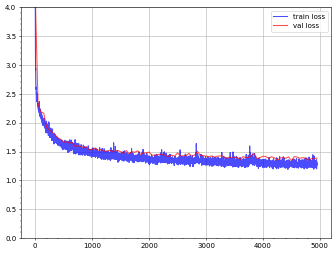

  0%|          | 0/5000 [00:00<?, ?it/s]

final loss: 1.3442387580871582 final val loss: 1.3860230565071106


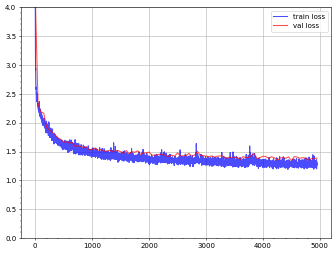

In [ ]:
# training!
model = SCANTransformerLM(config)
# model = torch.compile(model)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [ ]:
# Save
torch.save(model.state_dict(), 'models/TritonSCANTransformerLM.pt')

In [45]:
# Load model
model = SCANTransformerLM(config)
# model = torch.compile(model)
model.load_state_dict(torch.load('models/TritonSCANTransformerLM.pt'))
model.to(device)

C:\Users\Khalid Zuhri\AppData\Local\Temp\ipykernel_18548\994828852.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/TritonSCANTra

SCANTransformerLM(
  (token_embedding_table): Embedding(87, 128)
  (lm_head): Linear(in_features=128, out_features=87, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x SCANBlock(
      (sa_heads): MultiHeadSCAttention(
        (heads): ModuleList(
          (0-1): 2 x SCAttentionHead(
            (stator): Linear(in_features=128, out_features=64, bias=False)
            (integrator): Linear(in_features=128, out_features=32, bias=False)
            (key): Linear(in_features=128, out_features=64, bias=False)
            (query): Linear(in_features=128, out_features=64, bias=False)
            (value): Linear(in_features=128, out_features=64, bias=False)
          )
        )
        (o): Linear(in_features=128, out_features=128, bias=True)
      )
      (ff_layer): FeedForward(
        (lin_1): Linear(in_features=128, out_features=512, bias=True)
        (lin_2): Linear(in_features=512, out_features=128, bias=True)
        (relu): ReLU()
      )
      (sa_norm): RMSNorm()
      (ff_norm

In [47]:
model.eval()
idx = encode("""You will never be as good as me.
             
I have trained for thousan""")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000, temperature=0.5, use_cache=True)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75,  1, 59, 62,  1, 58, 76,  1, 64, 72, 72, 61,  1, 58, 76,  1, 70, 62, 10,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0, 37,  1, 65, 58, 79, 62,  1, 77, 75, 58, 66, 71, 62, 61,  1, 63, 72, 75,  1, 77, 65, 72, 78, 76, 58, 71]])
You will never be as good as me.
             
I have trained for thousands, so I can't see it to sure again.

I'm on the probably sure that you want to play a real to hear the top the way to be soul about the raining.

She was confident a lot of the lick of the power of the power of the truth.

Hey, what is he said the first time to the manga does.

I see, I can't have the one who well with my mission attacks.

Can't you tell me your problem?

It says that means that battle was hopeless anything straight.

Now that I was the same as a past as your power?

And that I didn't have a day this one who are happened.

And then why did you think you're all right now.

And that the more is the co

## Classic Transformer

In [38]:
class TransformerConfig:
    def __init__(self, vocab_size, seq_len, embed_size, head_num, layer_num):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.embed_size = embed_size
        self.head_num = head_num
        self.layer_num = layer_num

def build_alibi_tensor(head_num: int, seq_len: int) -> torch.Tensor:
    # Create position indices
    pos = torch.arange(seq_len, device=device)
    # Create slopes for each head: 2^(-8i/h) for i in [0,h)
    slopes = torch.pow(2, -8.0 * torch.arange(head_num, device=device) / head_num)
    # Compute relative positions using broadcasting
    # This creates a seq_len x seq_len matrix of position differences
    relative_pos = pos[None, :] - pos[:, None]  # shape: (seq_len, seq_len)
    # Multiply slopes by relative positions using broadcasting
    # slopes[:, None, None] creates a (head_num, 1, 1) tensor
    # relative_pos[None, :, :] creates a (1, seq_len, seq_len) tensor
    alibi = slopes[:, None, None] * relative_pos[None, :, :]
    return alibi

class RMSNorm(torch.nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class SelfAttentionHead(nn.Module):
    """ one head of self-attention with AliBi """
    def __init__(self, config):
        super().__init__()
        self.seq_len = config.seq_len
        self.key = nn.Linear(config.embed_size, config.embed_size//config.head_num, bias=False)
        self.query = nn.Linear(config.embed_size, config.embed_size//config.head_num, bias=False)
        self.value = nn.Linear(config.embed_size, config.embed_size//config.head_num, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(config.seq_len, config.seq_len)))

    def forward(self, x, alibi, kv_cache=None):
        B, T, C = x.shape
        _, T_past, _ = kv_cache[0].shape if kv_cache is not None and kv_cache[0] is not None else (0, 0, 0)
        q = self.query(x) # (B,T,C)
        k = self.key(x)   # (B,T,C)
        v = self.value(x) # (B,T,C)

        if kv_cache is not None:
            k_past, v_past = kv_cache
            if k_past is not None:
                k = torch.cat((k_past, k), dim=1)
                v = torch.cat((v_past, v), dim=1)
            if k.shape[1] > self.seq_len:
                k = k[:, -self.seq_len:]
                v = v[:, -self.seq_len:]
                alibi = alibi[-self.seq_len:, -self.seq_len:]
            kv_cache = (k, v)

        T_k = k.shape[1]
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei * C**-0.5 # scaled attention
        wei = wei + alibi[-T:, -T_k:] # add AliBi
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        # perform the weighted aggregation of the values
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out, kv_cache
    
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.lin_1 = nn.Linear(config.embed_size, config.embed_size*4)
        self.lin_2 = nn.Linear(config.embed_size*4, config.embed_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.lin_1(x)
        x = self.relu(x)
        x = self.lin_2(x)
        return x

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention with AliBi in parallel """
    def __init__(self, config):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(config) for _ in range(config.head_num)])
        self.o = nn.Linear(config.embed_size, config.embed_size)

    def forward(self, x, alibi, kv_cache=None):
        head_outs = [h(x, alibi[i], None if kv_cache is None else kv_cache[i]) for i, h in enumerate(self.heads)]
        kv_cache = [h[1] for h in head_outs]
        out = torch.cat([h[0] for h in head_outs], dim=-1) # concat single-head results
        out = self.o(out)
        return out, kv_cache

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_heads = MultiHeadAttention(config)
        self.ff_layer = FeedForward(config)
        self.sa_norm = RMSNorm(config.embed_size)
        self.ff_norm = RMSNorm(config.embed_size)
    
    def forward(self, x, alibi, kv_cache=None):
        a, kv_cache = self.sa_heads(self.sa_norm(x), alibi, kv_cache)
        h = x + a
        o = h + self.ff_layer(self.ff_norm(h))
        return o, kv_cache
    
class TransformerLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer_num = config.layer_num
        self.head_num = config.head_num
        self.seq_len = config.seq_len
        # embed raw tokens to a lower dimensional embedding with embed_size
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.embed_size)
        # Language Modelling (?) Head is a standard linear layer to go from 
        # embeddings back to logits of vocab_size
        self.lm_head = nn.Linear(config.embed_size, config.vocab_size)
        # transformer blocks
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.layer_num)])
        # precompute AliBi tensor
        self.alibi = build_alibi_tensor(config.head_num, config.seq_len)

    def forward(self, idx, targets=None, kv_cache=None):
        B, T = idx.shape
        _, T_past, _ = kv_cache[0][0][0].shape if kv_cache is not None and kv_cache[0][0][0] is not None else (0, 0, 0)
        # idx and targets are both (B,T) tensor of integers
        tok_embd = self.token_embedding_table(idx) # (B,T,C)
        x = tok_embd
        # go through blocks
        alibi = self.alibi[:, :T_past+T, :T_past+T]
        for i, block in enumerate(self.blocks):
            x, cache = block(x, alibi, None if kv_cache is None else kv_cache[i])
            if kv_cache is not None:
                kv_cache[i] = cache
        # get logits with linear layer
        logits = self.lm_head(x) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1, use_cache=True):
        if use_cache:
            # initialize key-value cache
            kv_cache = [[(None, None) for _ in range(self.head_num)] for _ in range(self.layer_num)]
            # idx is (B, T) array of indices in the current context
            # crop idx to the last seq_len tokens
            idx_context = idx[:, -self.seq_len:]
            for _ in range(max_new_tokens):
                # get the predictions
                logits, loss = self(idx_context, kv_cache=kv_cache)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
                # since we have kv cache, only need to pass new token
                idx_context = idx_next
            return idx
        else:
            # idx is (B, T) array of indices in the current context
            for _ in range(max_new_tokens):
                #crop idx to the last seq_len tokens
                idx_context = idx[:, -self.seq_len:]
                # get the predictions
                logits, loss = self(idx_context)
                # focus only on the last time step
                logits = logits[:, -1, :] # becomes (B, C)
                # apply temperature
                logits = logits / temperature if temperature > 0 else logits
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) if temperature > 0 else torch.argmax(probs, dim=-1, keepdim=True) # (B, 1)
                # append sampled index to the running sequence
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            return idx

In [39]:
# Test forward pass
config = TransformerConfig(
    vocab_size=vocab_size,
    seq_len=seq_len,
    embed_size=128,
    head_num=2,
    layer_num=3
)
m = TransformerLM(config)
m.to(device)
xb, yb = get_batch('train', 5, 1)
logits, loss = m(xb, yb)
total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
total_params

615255

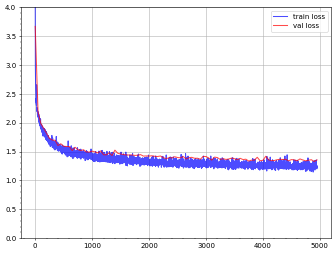

  0%|          | 0/5000 [00:00<?, ?it/s]

final loss: 1.2193772792816162 final val loss: 1.3547022700309754


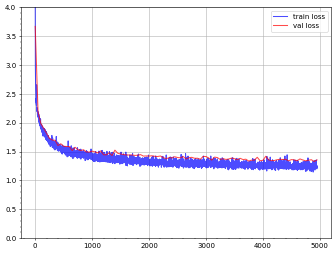

In [40]:
# training!
model = TransformerLM(config)
# model = torch.compile(model)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
train(model, optimizer, seq_len, batch_size, total_steps)

In [41]:
model.eval()
idx = encode("You will never b")
print(torch.tensor([idx]))
print(decode(model.generate(idx=torch.tensor([idx], dtype=torch.long).to(device), max_new_tokens=1000, temperature=0.5, use_cache=True)[0].tolist()))

tensor([[53, 72, 78,  1, 80, 66, 69, 69,  1, 71, 62, 79, 62, 75,  1, 59]])
You will never be able to see the fire.

Are you all right now?

She wanted to take the way to the start of the lords of the same.

I'm sorry. I wouldn't see her from the way to the propose of the last strand.

I was so easily doing.

I knew it, but I couldn't be happy.

But I can't do it.

I'm sorry. I want to see.

What are you to do with that?

I was so so sure that man.

I was so far broken to come here, and that to me.

What do you mean?

I can't tell you that you were to work to work.

You still hard to so any program.

I wasn't that the true, though.

I know where I can see he like this?

I see...

I love it was a thing in the same room into a handing and not be so too much.

The problem to be fine.

I can take that all the way to the director of the souls.

I'm sorry. I'm sorry.

I won't say that someone like you can go down the way.

I can't be so sorry.

I want to go and the book the planet with right 